# Custom Feature Detection: Bubble tracking in 2D foams

As illustrated in the [walktrough example](http://nbviewer.ipython.org/github/soft-matter/trackpy-examples/blob/master/notebooks/walkthrough.ipynb), the tracking relies on two steps:

* the detection of features
* the tracking of these features

In many situations, we track particles. However, it is also possible to track other features such as bubbles. Trackpy provides a 'locate' function to detect particles, seen as spots. But, in the case of bubbles in foams, bubbles are in contact with their neighbors and the 'locate' function could not detect their position.

In this notebook, we show that we can apply a custom method to detect the position of the bubbles and then, pass the list to the tracking algorithm.

## Scientific libraries

In [1]:
# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

import numpy as np
import pandas as pd

import pims
import trackpy as tp
import os

import matplotlib  as mpl 
import matplotlib.pyplot as plt 

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

In [2]:
datapath = '../sample_data/foam'
prefix = 'V1.75f3.125000'

## Image preprocessing

First, we load the batch of pictures and we display the first image

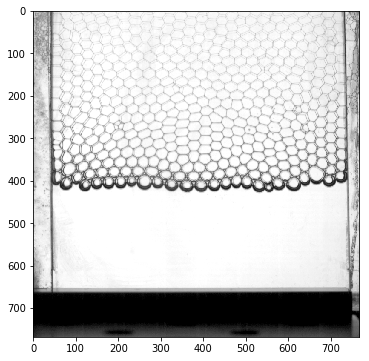

In [3]:
id_example = 4
rawframes = pims.ImageSequence(os.path.join(datapath, prefix + '*.tif'), process_func=None)
plt.imshow(rawframes[id_example]);

Because, we will need to apply several image processing steps to detect the positions of the bubbles, we crop the picture to keep only the region of interest. This is done by passing a preprocessing function to 'ImageSequence'.

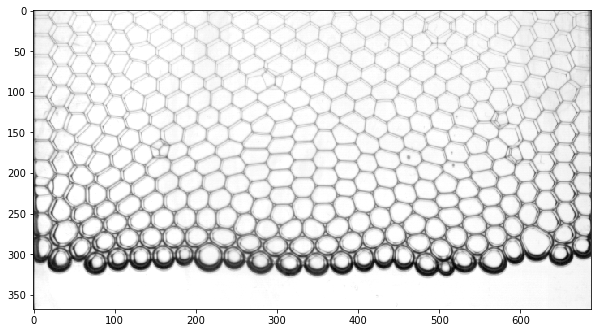

In [4]:
def crop(img):
    """
    Crop the image to select the region of interest
    """
    x_min = 45
    x_max = -35
    y_min = 100
    y_max = -300 
    return img[y_min:y_max,x_min:x_max]

rawframes = pims.ImageSequence(os.path.join(datapath, prefix + '*.tif'), process_func=crop)
plt.imshow(rawframes[id_example]);

The next step is to use [scikit-image](http://scikit-image.org/)[1] to make a binary image of the edge of the bubbles. It usually requires several trials before getting a successful procedure. This package can be installed by running:

```
pip install scikit-image
```

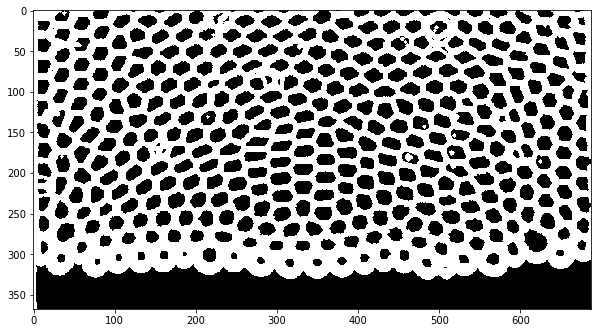

In [5]:
from scipy import ndimage
from skimage import morphology, util, filters


def preprocess_foam(img):
    """
    Apply image processing functions to return a binary image
    """
    # Crop the pictures as for raw images.
    img = crop(img)
    # Apply thresholds
    adaptive_thresh = filters.threshold_local(img,301)
    idx = img > adaptive_thresh
    idx2 = img < adaptive_thresh
    img[idx] = 0
    img[idx2] = 255
    img = ndimage.binary_dilation(img)
    img = ndimage.binary_dilation(img)
    return util.img_as_int(img)


frames = pims.ImageSequence(os.path.join(datapath, prefix + '*.tif'), process_func=preprocess_foam)
plt.imshow(frames[id_example]);

## Custom feature detection

Our features are the bubbles represented by the small black areas surrounded by white edges. Note that the black area at  the bottom is the liquid should not be considered as a feature. We use again scikit-image with the labeling function to detect the bubbles. The function returns several values such as the positon, the mean intensity, the area, the excentricity, etc. that can be used to remove false-postive labels. In our example, we must choose smart criterions because the bubble size is clearly different on the top and on the bottom.

We make a test on one picture first to seek and validate our criterions. We use matplotlib to draw rectangles around each feature.

Found 407 features


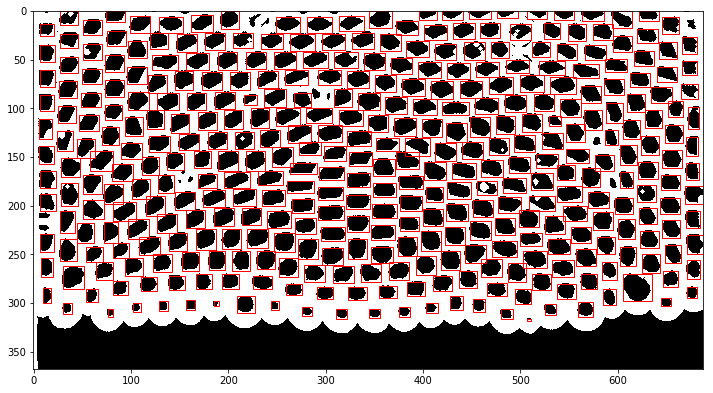

In [6]:
import skimage
import matplotlib.patches as mpatches

img_example = frames[id_example]

# Label elements on the picture
white = 255
label_image, number_of_labels = skimage.measure.label(img_example, background=white, return_num=True)
print("Found %d features"%(number_of_labels))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
ax.imshow(img_example)
for region in skimage.measure.regionprops(label_image, intensity_image=img_example):
    # Everywhere, skip small and large areas
    if region.area < 5 or region.area > 800:
        continue
    # Only black areas
    if region.mean_intensity > 1:
        continue
    # On the top, skip small area with a second threshold
    if region.centroid[0] < 260 and region.area < 80:
        continue
    # Draw rectangle which survived to the criterions
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=1)

    ax.add_patch(rect)

Now, we use this algorithm on each picture of the stack. The features are stored in a pandas DataFrame [2].

In [7]:
features = pd.DataFrame()
for num, img in enumerate(frames):
    white = 255
    label_image = skimage.measure.label(img, background=white)
    for region in skimage.measure.regionprops(label_image, intensity_image=img):
        # Everywhere, skip small and large areas
        if region.area < 5 or region.area > 800:
            continue
        # Only black areas
        if region.mean_intensity > 1:
            continue
        # On the top, skip small area with a second threshold
        if region.centroid[0] < 260 and region.area < 80: 
            continue
        # Store features which survived to the criterions
        features = features.append([{'y': region.centroid[0],
                                     'x': region.centroid[1],
                                     'frame': num,
                                     },])

We can also use 'annotate' provided with trackpy to display the features which will be track in the next step.

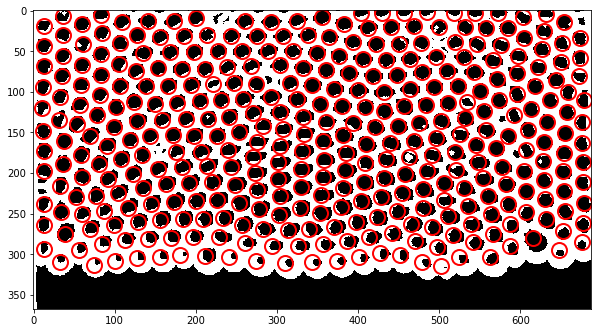

In [8]:
tp.annotate(features[features.frame==(id_example+1)], img_example);

## Bubble tracking

As for particle tracking, this step links the successive positions of each feature. We superimpose the trajectories with the first picture to check their consistancy.

Frame 8: 365 trajectories present


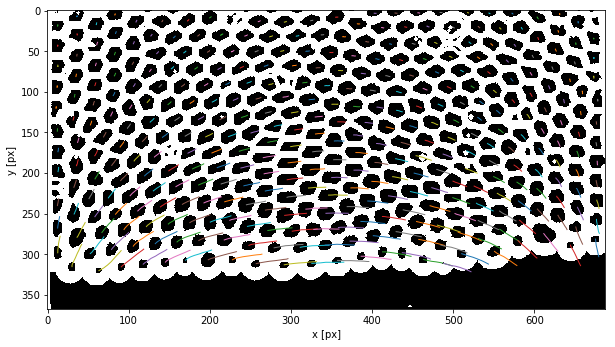

In [9]:
search_range = 11
t = tp.link_df(features, search_range, memory=5, diagnostics=True)
tp.plot_traj(t, superimpose=img)

In [10]:
#from pprint import pprint
#pprint(t.sort_values('frame'))
# The first frame is the only frame with any particles!

In [11]:
unstacked = t.set_index(['frame', 'particle']).unstack()

## Velocity field

### Step 1: calculation

With the position of the center of mass of each bubble, we can calculate the velocity vector.

In [12]:
data = pd.DataFrame()
for item in set(t.particle):
    sub = t[t.particle==item]
    dvx = np.diff(sub.x)
    dvy = np.diff(sub.y)
    for x, y, dx, dy, frame in zip(sub.x[:-1], sub.y[:-1], dvx, dvy, sub.frame[:-1],):
        data = data.append([{'dx': dx, 
                             'dy': dy, 
                             'x': x,
                             'y': y,
                             'frame': frame,
                             'particle': item,
                            }]) 

### Step 2: rendering

We now display the picture and plot the velocity field on the top with matplotlib[3]. Here, we plot only the first picture for illustrative purposes.

In [13]:
from matplotlib.pyplot import quiver

(-0.5, 687.5, 367.5, -0.5)

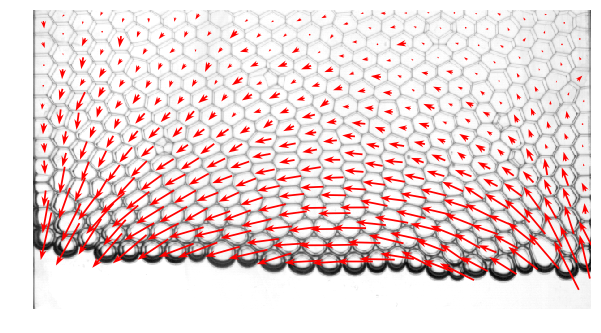

In [14]:
i = 0
d = data[data.frame==i]
plt.imshow(rawframes[i])
plt.quiver(d.x, d.y, d.dx, -d.dy, pivot='middle', headwidth=4, headlength=6, color='red')
plt.axis('off')

## About this work

This presentation is based on a scientific work which aims to understand the damping of a thin layer of foam placed on the top of an oscillating liquid bath. The main idea of this work is presented in the reference [4] and the scientific results are in reference [5]. This work has been performed in Princeton University (USA) by all the co-authors and this presentation has been written by F. Boulogne.

## References

[1] Stéfan van der Walt, Johannes L. Schönberger, Juan Nunez-Iglesias, François Boulogne, Joshua D. Warner, Neil Yager, Emmanuelle Gouillart, Tony Yu and the scikit-image contributors. scikit-image: Image processing in Python. PeerJ 2:e453, 2014. http://dx.doi.org/10.7717/peerj.453 

[2] Wes Mckinney. Data structures for statistical computing in Python. In : Proc. 9th Python Sci. Conf. 2010. p. 51-56.

[3] Hunter, John D. Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 2007, vol. 9, no 3, p. 90-95.

[4] J. Cappello, A. Sauret, F. Boulogne, E. Dressaire and H.A. Stone, Journal of Visualization, 18, 269-271 (2015). http://arxiv.org/abs/1411.2123

[5] A. Sauret, F. Boulogne, J. Cappello, E. Dressaire and H.A. Stone, Physics of Fluids, 27 (2015). http://arxiv.org/abs/1411.6542